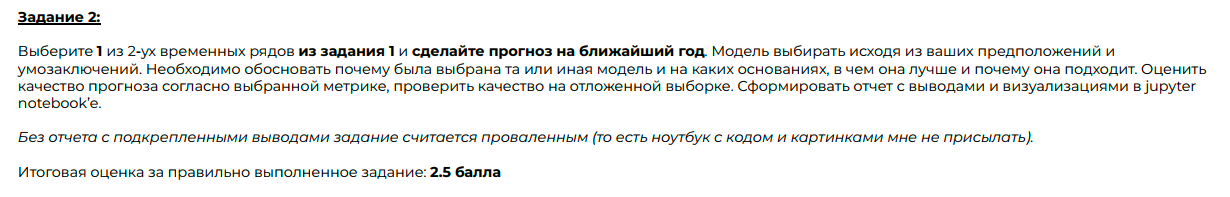

In [1]:
!pip install --upgrade mplfinance
from mplfinance.original_flavor import candlestick_ohlc
!pip install yfinance
import yfinance as yf
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import pandas as pd
from pandas.plotting import autocorrelation_plot
import warnings
import numpy as np
import seaborn as sns
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
import scipy.stats as scs
from itertools import product
from tqdm import tqdm_notebook

sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 70 kB 4.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
!pip install watermark --quiet
%load_ext watermark
%watermark -a 'Anrei Sech' -v

     |████████████████████████████████| 1.6 MB 11.9 MB/s 
Author: Anrei Sech

Python implementation: CPython
Python version       : 3.7.15
IPython version      : 7.9.0



В файле "1. Time series. Financial analisys.ipynb" анализировалась цена акций компаний Amazon и Ford. Согласно заданию, возьмем для прогнозирования один из указанных временных рядов: цена закрытия для акций компании Ford

In [3]:
def get_price_data(ticker):
    tickerData = yf.Ticker(ticker)
    tickerDf = tickerData.history(period='1d', start='2017-1-1', end='2022-10-1')
    return tickerDf.iloc[:, :5]

In [4]:
df = get_price_data('F')
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03 00:00:00-05:00,9.676395,9.993654,9.620875,9.985723,40510800
2017-01-04 00:00:00-05:00,10.128486,10.525060,10.104691,10.445745,77638100
2017-01-05 00:00:00-05:00,10.477474,10.485406,10.017449,10.128489,75628400
2017-01-06 00:00:00-05:00,10.152282,10.184008,10.025378,10.120556,40315900
2017-01-09 00:00:00-05:00,10.144350,10.199870,10.017447,10.017447,39438400


In [5]:
df.index.Freq = 'B'
df['Close'].describe()

count    1447.000000
mean       10.358028
std         3.430422
min         3.904326
25%         8.439666
50%         9.389077
75%        11.820079
max        24.649670
Name: Close, dtype: float64

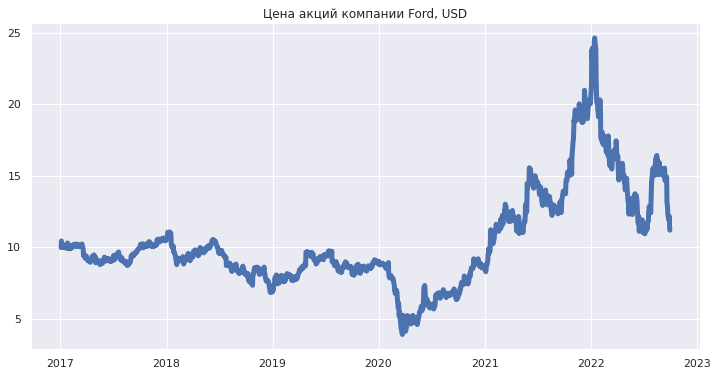

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], linewidth=5.0)
plt.title('Цена акций компании Ford, USD')
plt.show()

Как было показано ранее, данный ряд нестационарен. Операции вроде логарифмирования или boxcox также не приводили его к стационарности, однако в результате дифференцирования получается подходящий для прогнозирования стационарный ряд. Таким образом, избавимся от стационарности путем дифференцирования

In [7]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, zero=False)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, zero=False)
        plt.tight_layout()

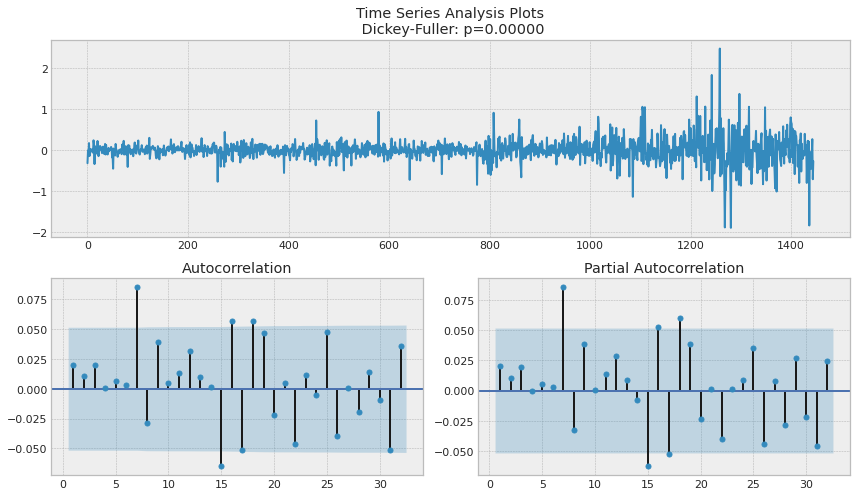

In [8]:
diff_time_series = np.diff(df['Close'], 1)
tsplot(diff_time_series[1:])

In [9]:
diff_time_series = np.insert(diff_time_series, 0, 0)
df['diff'] = diff_time_series
for i in range(12):
    print(i+1, df['diff'].autocorr(lag=i+1))

1 0.018932699855550496
2 0.010895142943382136
3 0.019871120159673645
4 0.0012972200525485876
5 0.00552004646394104
6 0.0031274353653448256
7 0.08576272935658312
8 -0.02885921503897346
9 0.03958037379666199
10 0.00495140420124547
11 0.013303513308711185
12 0.032152495845355414


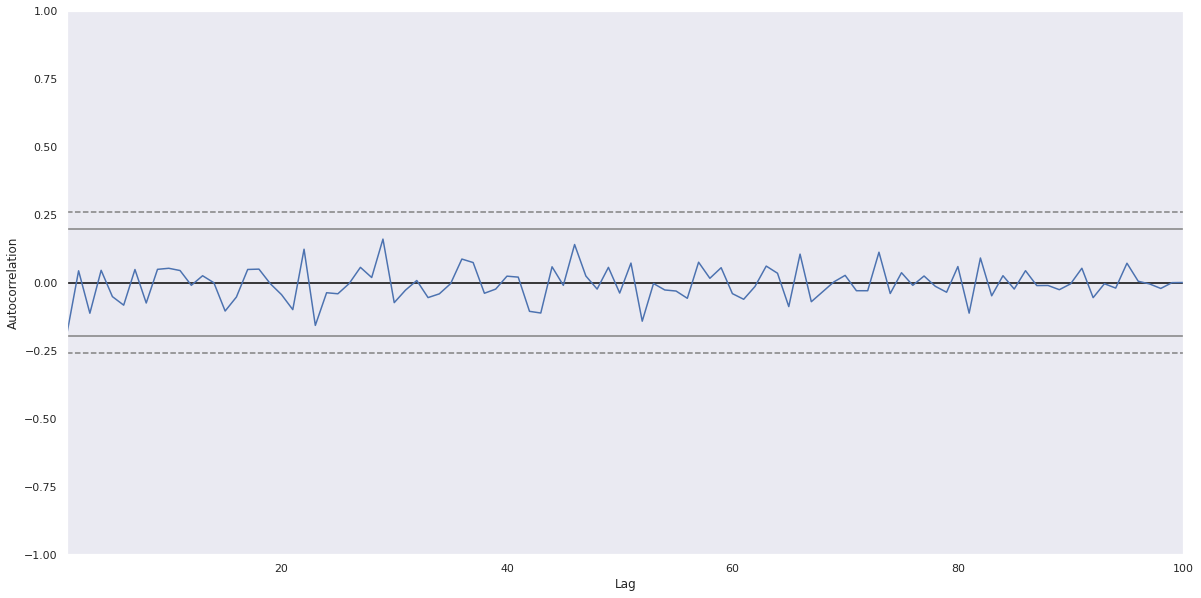

In [10]:
plt.figure(figsize=(20,10))
autocorrelation_plot(diff_time_series[:100])
plt.show()

Как видно, нет какого-то одного периода, который бы превалировал в определении текущего значения временного ряда, выраженная сезонность также не прослеживается

Ввиду того, что сезоность отсутствует, попробуем воспользоваться сразу простыми авторегрессионными моделями из семейства моделей ARIMA (ARMA) с различными параметрами с постенныем усложнением при необходимости. После этого проанализируем качество полученных моделей

Подготовим dataset. В качестве тестовых данных возьмем данные за текущий (2022) год и будем строить для него прогноз

In [66]:
train_df = df.loc[:'2021-12-31']
test_df = df.loc['2022-01-01':]

In [12]:
train_df[['Close', 'diff']].tail(), test_df[['Close', 'diff']].head()

(                               Close      diff
 Date                                          
 2021-12-27 00:00:00-05:00  20.353836  0.538202
 2021-12-28 00:00:00-05:00  20.314695 -0.039141
 2021-12-29 00:00:00-05:00  20.118984 -0.195711
 2021-12-30 00:00:00-05:00  20.030914 -0.088070
 2021-12-31 00:00:00-05:00  20.324480  0.293566,
                                Close      diff
 Date                                          
 2022-01-03 00:00:00-05:00  21.303030  0.978550
 2022-01-04 00:00:00-05:00  23.788548  2.485518
 2022-01-05 00:00:00-05:00  23.152489 -0.636059
 2022-01-06 00:00:00-05:00  23.935328  0.782839
 2022-01-07 00:00:00-05:00  23.915758 -0.019569)

AR(5) model

In [30]:
model_ar_5 = ARMA(train_df['diff'], order=(5,0))
results_ar_5 = model_ar_5.fit()
results_ar_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   diff   No. Observations:                 1259
Model:                     ARMA(5, 0)   Log Likelihood                 139.064
Method:                       css-mle   S.D. of innovations              0.217
Date:                Tue, 25 Oct 2022   AIC                           -264.129
Time:                        17:31:53   BIC                           -228.162
Sample:                             0   HQIC                          -250.612
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0082      0.006      1.416      0.157      -0.003       0.019
ar.L1.diff    -0.0425      0.028     -1.507      0.132      -0.098       0.013
ar.L2.diff    -0.0516      0.028     -1.830      0.067      -0.107       0.004
ar.L3.diff     0.0453      0.028      1.605      0.108      -0.010       0.101
ar.L4.diff     0.0275      0.028      0.974      0.330      -0.028       0.083
ar.L5.diff    -0.0372      0.028     -1.314      0.189      -0.093       0.018
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.9515           -0.0000j            1.9515           -0.5000
AR.2           -0.4867           -1.6598j            1.7297           -0.2954
AR.3           -0.4867           +1.6598j            1.7297            0.2954
AR.4            1.8326           -1.1181j            2.1467           -0.0872
AR.5            1.8326           +1.1181j            2.1467            0.0872
-----------------------------------------------------------------------------
"""

AR(10) model

In [31]:
model_ar_10 = ARMA(train_df['diff'], order=(10,0))
results_ar_10 = model_ar_10.fit()
results_ar_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   diff   No. Observations:                 1259
Model:                    ARMA(10, 0)   Log Likelihood                 150.947
Method:                       css-mle   S.D. of innovations              0.215
Date:                Tue, 25 Oct 2022   AIC                           -277.893
Time:                        17:32:26   BIC                           -216.236
Sample:                             0   HQIC                          -254.723
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0082      0.007      1.238      0.216      -0.005       0.021
ar.L1.diff     -0.0382      0.028     -1.360      0.174      -0.093       0.017
ar.L2.diff     -0.0445      0.028     -1.582      0.114      -0.100       0.011
ar.L3.diff      0.0333      0.028      1.183      0.237      -0.022       0.088
ar.L4.diff      0.0248      0.028      0.883      0.377      -0.030       0.080
ar.L5.diff     -0.0275      0.028     -0.980      0.327      -0.083       0.028
ar.L6.diff      0.0109      0.028      0.389      0.697      -0.044       0.066
ar.L7.diff      0.0844      0.028      2.994      0.003       0.029       0.140
ar.L8.diff     -0.0555      0.028     -1.964      0.049      -0.111      -0.000
ar.L9.diff      0.0208      0.028      0.737      0.461      -0.035       0.076
ar.L10.diff     0.0828      0.028      2.920      0.004       0.027       0.138
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.2548           -0.0000j            1.2548           -0.0000
AR.2             1.0422           -0.7902j            1.3079           -0.1032
AR.3             1.0422           +0.7902j            1.3079            0.1032
AR.4             0.4212           -1.2189j            1.2897           -0.1970
AR.5             0.4212           +1.2189j            1.2897            0.1970
AR.6            -0.3759           -1.1201j            1.1815           -0.3015
AR.7            -0.3759           +1.1201j            1.1815            0.3015
AR.8            -1.1076           -0.6533j            1.2859           -0.4152
AR.9            -1.1076           +0.6533j            1.2859            0.4152
AR.10           -1.4664           -0.0000j            1.4664           -0.5000
------------------------------------------------------------------------------
"""

При оценке качества модели необходимо обращать внимание на Log Likelihood и информационные критерии (AIC, BIC, HQIC). Если модель качественнее, она будет иметь меньше информационный критерий, в частности AIC. В данном случае необычно, что он отрицательный. Но при сравнение в первую очередь важен не знак или абсолютное значение, а у какой модели он ниже или выше.
Для оценки того, статически является ли модель более значимой, есть Log Likelihood (LLR) test. В нем используется статистика Xi2, df (degree of freedom) - число степеней свободы. При низком значении p-value (менее 0.05) модель статистически значимо лучше. Воспользуемся им при сравнении наших моделей:

In [32]:
def LLR_test(model_1, model_2, df=1):
    l1 = model_1.fit().llf
    l2 = model_2.fit().llf
    lr = 2 * (l2 - l1)
    p = scs.distributions.chi2.sf(lr, df).round(3)
    return p

In [33]:
LLR_test(model_ar_5, model_ar_10)

0.0

По результатам теста AR(10) модель лучше, чем AR(5)

AR(15) model

In [35]:
model_ar_15 = ARMA(train_df['diff'], order=(15,0))
results_ar_15 = model_ar_15.fit()
results_ar_15.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   diff   No. Observations:                 1259
Model:                    ARMA(15, 0)   Log Likelihood                 156.325
Method:                       css-mle   S.D. of innovations              0.214
Date:                Tue, 25 Oct 2022   AIC                           -278.650
Time:                        17:35:00   BIC                           -191.303
Sample:                             0   HQIC                          -245.825
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0082      0.007      1.120      0.263      -0.006       0.023
ar.L1.diff     -0.0413      0.028     -1.465      0.143      -0.096       0.014
ar.L2.diff     -0.0480      0.028     -1.699      0.089      -0.103       0.007
ar.L3.diff      0.0294      0.028      1.042      0.298      -0.026       0.085
ar.L4.diff      0.0247      0.028      0.876      0.381      -0.031       0.080
ar.L5.diff     -0.0275      0.028     -0.976      0.329      -0.083       0.028
ar.L6.diff      0.0079      0.028      0.281      0.778      -0.047       0.063
ar.L7.diff      0.0800      0.028      2.829      0.005       0.025       0.135
ar.L8.diff     -0.0521      0.028     -1.841      0.066      -0.108       0.003
ar.L9.diff      0.0181      0.028      0.640      0.522      -0.037       0.073
ar.L10.diff     0.0817      0.028      2.886      0.004       0.026       0.137
ar.L11.diff    -0.0048      0.028     -0.168      0.867      -0.060       0.051
ar.L12.diff     0.0614      0.028      2.164      0.030       0.006       0.117
ar.L13.diff     0.0566      0.028      1.993      0.046       0.001       0.112
ar.L14.diff     0.0300      0.029      1.045      0.296      -0.026       0.086
ar.L15.diff    -0.0373      0.030     -1.264      0.206      -0.095       0.021
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.2073           -0.0000j            1.2073           -0.5000
AR.2            -1.0660           -0.5393j            1.1946           -0.4255
AR.3            -1.0660           +0.5393j            1.1946            0.4255
AR.4            -0.3716           -1.0654j            1.1284           -0.3034
AR.5            -0.3716           +1.0654j            1.1284            0.3034
AR.6            -0.9314           -0.9747j            1.3482           -0.3714
AR.7            -0.9314           +0.9747j            1.3482            0.3714
AR.8             0.1495           -1.1979j            1.2072           -0.2302
AR.9             0.1495           +1.1979j            1.2072            0.2302
AR.10            0.6191           -1.0123j            1.1866           -0.1626
AR.11            0.6191           +1.0123j            1.1866            0.1626
AR.12            1.0029           -0.6132j            1.1755           -0.0873
AR.13            1.0029           +0.6132j            1.1755            0.0873
AR.14            1.1552           -0.0000j            1.1552           -0.0000
AR.15            2.0500           -0.0000j            2.0500           -0.0000
------------------------------------------------------------------------------
"""

In [36]:
LLR_test(model_ar_15, model_ar_10)

1.0

Как видим, дальнейшее усложнение модели не дает значимого прироста качества

ARMA(10,10) model

In [43]:
model_arma_10_10 = ARMA(train_df['diff'], order=(10,10))
results_arma_10_10 = model_arma_10_10.fit()
results_arma_10_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   diff   No. Observations:                 1259
Model:                   ARMA(10, 10)   Log Likelihood                 158.463
Method:                       css-mle   S.D. of innovations              0.213
Date:                Tue, 25 Oct 2022   AIC                           -272.927
Time:                        17:46:56   BIC                           -159.889
Sample:                             0   HQIC                          -230.447
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0084      0.007      1.184      0.237      -0.005       0.022
ar.L1.diff      0.5217        nan        nan        nan         nan         nan
ar.L2.diff      0.1659      0.232      0.715      0.475      -0.289       0.621
ar.L3.diff      0.2521      0.279      0.904      0.366      -0.295       0.799
ar.L4.diff     -0.6952        nan        nan        nan         nan         nan
ar.L5.diff      0.0792        nan        nan        nan         nan         nan
ar.L6.diff      0.2286      0.421      0.543      0.587      -0.596       1.053
ar.L7.diff      0.5080        nan        nan        nan         nan         nan
ar.L8.diff     -0.1667        nan        nan        nan         nan         nan
ar.L9.diff     -0.3581      0.303     -1.184      0.237      -0.951       0.235
ar.L10.diff     0.1082        nan        nan        nan         nan         nan
ma.L1.diff     -0.5627        nan        nan        nan         nan         nan
ma.L2.diff     -0.1913      0.088     -2.179      0.029      -0.363      -0.019
ma.L3.diff     -0.1875      0.248     -0.756      0.449      -0.674       0.298
ma.L4.diff      0.7284        nan        nan        nan         nan         nan
ma.L5.diff     -0.1574        nan        nan        nan         nan         nan
ma.L6.diff     -0.2366      0.445     -0.532      0.595      -1.108       0.635
ma.L7.diff     -0.3923        nan        nan        nan         nan         nan
ma.L8.diff      0.1124        nan        nan        nan         nan         nan
ma.L9.diff      0.3874      0.261      1.485      0.137      -0.124       0.898
ma.L10.diff    -0.0807        nan        nan        nan         nan         nan
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -0.3332           -1.0232j            1.0761           -0.3001
AR.2            -0.3332           +1.0232j            1.0761            0.3001
AR.3            -0.8211           -0.6742j            1.0625           -0.3906
AR.4            -0.8211           +0.6742j            1.0625            0.3906
AR.5            -1.4262           -0.0000j            1.4262           -0.5000
AR.6             0.6758           -0.7472j            1.0075           -0.1330
AR.7             0.6758           +0.7472j            1.0075            0.1330
AR.8             1.1996           -0.2096j            1.2177           -0.0275
AR.9             1.1996           +0.2096j            1.2177            0.0275
AR.10            3.2931           -0.0000j            3.2931           -0.0000
MA.1            -0.7947           -0.6894j            1.0521           -0.3863
MA.2            -0.7947           +0.6894j            1.0521            0.3863
MA.3            -1.3752           -0.0000j            1.3

In [45]:
LLR_test(model_ar_10, model_arma_10_10)

0.0

ARMA(10,20) model

In [49]:
model_arma_10_20 = ARMA(train_df['diff'], order=(10,20))
results_arma_10_20 = model_arma_10_20.fit()
results_arma_10_20.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   diff   No. Observations:                 1259
Model:                   ARMA(10, 20)   Log Likelihood                 171.491
Method:                       css-mle   S.D. of innovations              0.211
Date:                Tue, 25 Oct 2022   AIC                           -278.982
Time:                        18:36:13   BIC                           -114.564
Sample:                             0   HQIC                          -217.194
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0080      0.007      1.149      0.251      -0.006       0.022
ar.L1.diff      0.2166      0.201      1.080      0.280      -0.177       0.610
ar.L2.diff      0.2866      0.211      1.360      0.174      -0.127       0.700
ar.L3.diff     -1.0315      0.196     -5.258      0.000      -1.416      -0.647
ar.L4.diff     -0.4801      0.157     -3.063      0.002      -0.787      -0.173
ar.L5.diff      0.0979      0.166      0.590      0.555      -0.227       0.423
ar.L6.diff      0.0670      0.154      0.434      0.664      -0.235       0.369
ar.L7.diff     -1.0938      0.156     -6.995      0.000      -1.400      -0.787
ar.L8.diff      0.0330      0.213      0.155      0.877      -0.384       0.450
ar.L9.diff      0.1031      0.189      0.546      0.585      -0.267       0.474
ar.L10.diff    -0.6323      0.162     -3.915      0.000      -0.949      -0.316
ma.L1.diff     -0.2572      0.199     -1.290      0.197      -0.648       0.134
ma.L2.diff     -0.3263      0.216     -1.511      0.131      -0.749       0.097
ma.L3.diff      1.0878      0.197      5.526      0.000       0.702       1.474
ma.L4.diff      0.4790      0.171      2.800      0.005       0.144       0.814
ma.L5.diff     -0.2107      0.177     -1.193      0.233      -0.557       0.135
ma.L6.diff     -0.0437      0.167     -0.261      0.794      -0.372       0.284
ma.L7.diff      1.2535      0.171      7.317      0.000       0.918       1.589
ma.L8.diff     -0.1785      0.245     -0.730      0.466      -0.658       0.301
ma.L9.diff     -0.1458      0.230     -0.633      0.527      -0.597       0.306
ma.L10.diff     0.8746      0.198      4.425      0.000       0.487       1.262
ma.L11.diff    -0.0565      0.065     -0.876      0.381      -0.183       0.070
ma.L12.diff    -0.0394      0.064     -0.613      0.540      -0.165       0.087
ma.L13.diff     0.1773      0.061      2.917      0.004       0.058       0.296
ma.L14.diff     0.1214      0.052      2.325      0.020       0.019       0.224
ma.L15.diff    -0.1128      0.046     -2.427      0.015      -0.204      -0.022
ma.L16.diff     0.1099      0.053      2.076      0.038       0.006       0.214
ma.L17.diff     0.2505      0.056      4.503      0.000       0.141       0.360
ma.L18.diff    -0.1194      0.033     -3.634      0.000      -0.184      -0.055
ma.L19.diff     0.0185      0.041      0.454      0.650      -0.061       0.098
ma.L20.diff     0.1294      0.039      3.358      0.001       0.054       0.205
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -0.6536           -0.7599j            1.0024           -0.3631
AR.2            -0.6536           +0.7599j            1.0024            0.3631
AR.3            -1.0088           -0.0000j     

Добавление к авторегрессионной модели (AR) скользящего среднего (MA) улучшило качество модели. Можно и дальше оптимизировать параметры, но пока остановимся на данной и проверим качество модели ARMA(10,20)

In [51]:
train_df['ARMA(10,20)'] = results_arma_10_20.predict(start=train_df.index[0], end=train_df.index[-1])

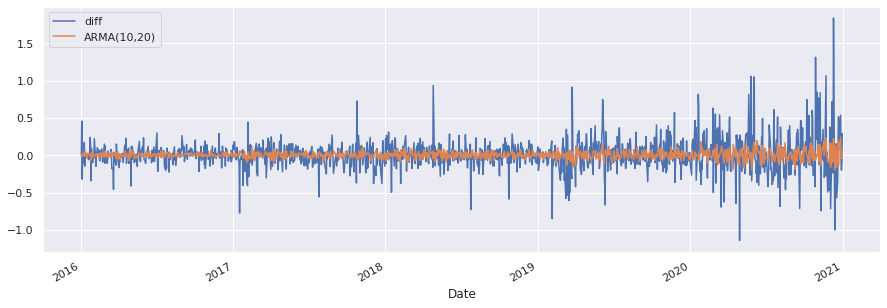

In [52]:
train_df[['diff', 'ARMA(10,20)']].plot(figsize=(15, 5));

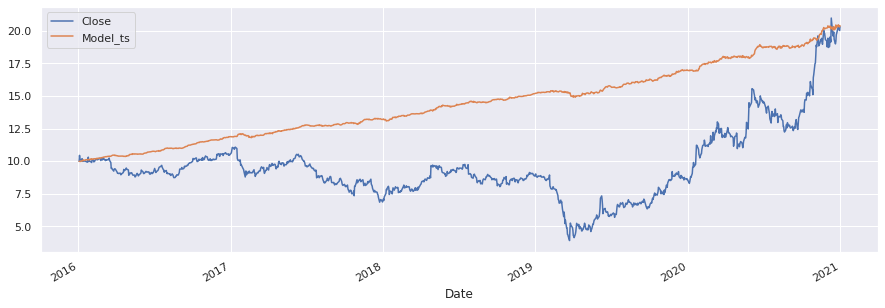

In [53]:
x, x_diff = train_df['Close'].iloc[0], train_df['ARMA(10,10)'].iloc[1:]
train_df['Model_ts'] = np.r_[x, x_diff].cumsum()
train_df[['Close', 'Model_ts']].plot(figsize=(15, 5));

Несмотря на стационарность, обучение на дифферинцированном временном ряде дает плохие результаты при восставновлении оригинального временного ряда. Прогноз оказывается завышенным. Ошибки будут одного знака, смещенные

Однако обучить модель напрямую на оригинальном датасете без преобразования в стационарный ряд в семействе моделей ARIMA не дает, это обязательное требование. Так что попробуем другую модель



In [60]:
!pip install prophet
from prophet import Prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
model_prophet = Prophet(changepoint_prior_scale=0.5,seasonality_prior_scale=0.01)

In [71]:
train_prophet = train_df['Close'].reset_index()

In [78]:
def remove_tz_from_dataframe(df_in):
    df = df_in.copy()
    col_times = [ 'Date' ]
    for col in col_times:
        df[col] = pd.to_datetime(
            df[col], infer_datetime_format=True) 
        df[col] = df[col].dt.tz_localize(None) 
    return df

In [79]:
train_prophet = remove_tz_from_dataframe(train_prophet)

In [80]:
model_prophet.fit(train_prophet.rename(columns={'Date':'ds', 'Close':'y'}))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0kwjrx5o/6fkgvi0b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0kwjrx5o/dk6hfvx1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25668', 'data', 'file=/tmp/tmp0kwjrx5o/6fkgvi0b.json', 'init=/tmp/tmp0kwjrx5o/dk6hfvx1.json', 'output', 'file=/tmp/tmp0kwjrx5o/prophet_modeltuieajyd/prophet_model-20221025194910.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:49:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:49:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [81]:
train_fb_prophet = remove_tz_from_dataframe(test_df['Close'].reset_index())

In [83]:
test_prophet = model_prophet.predict(df = train_fb_prophet.rename(columns={'Date':'ds', 'TWH_Generation':'y'}))

In [84]:
test_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-03,19.779489,20.326961,21.441279,19.779489,19.779489,1.072526,1.072526,1.072526,-0.007313,-0.007313,-0.007313,1.079840,1.079840,1.079840,0.0,0.0,0.0,20.852015
1,2022-01-04,19.811698,20.396143,21.473831,19.811698,19.811698,1.134929,1.134929,1.134929,0.010133,0.010133,0.010133,1.124796,1.124796,1.124796,0.0,0.0,0.0,20.946627
2,2022-01-05,19.843908,20.436601,21.552820,19.843908,19.843908,1.168784,1.168784,1.168784,-0.001767,-0.001767,-0.001767,1.170551,1.170551,1.170551,0.0,0.0,0.0,21.012692
3,2022-01-06,19.876117,20.517619,21.646629,19.876117,19.876117,1.207145,1.207145,1.207145,-0.009615,-0.009615,-0.009615,1.216760,1.216760,1.216760,0.0,0.0,0.0,21.083262
4,2022-01-07,19.908327,20.577801,21.738844,19.908327,19.908327,1.264446,1.264446,1.264446,0.001381,0.001381,0.001381,1.263065,1.263065,1.263065,0.0,0.0,0.0,21.172772


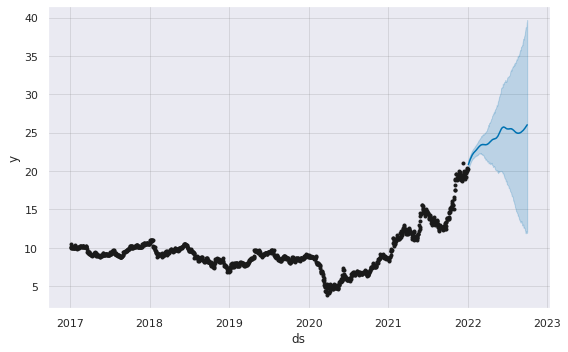

In [85]:
fig = model_prophet.plot(test_prophet, figsize=(8,5))

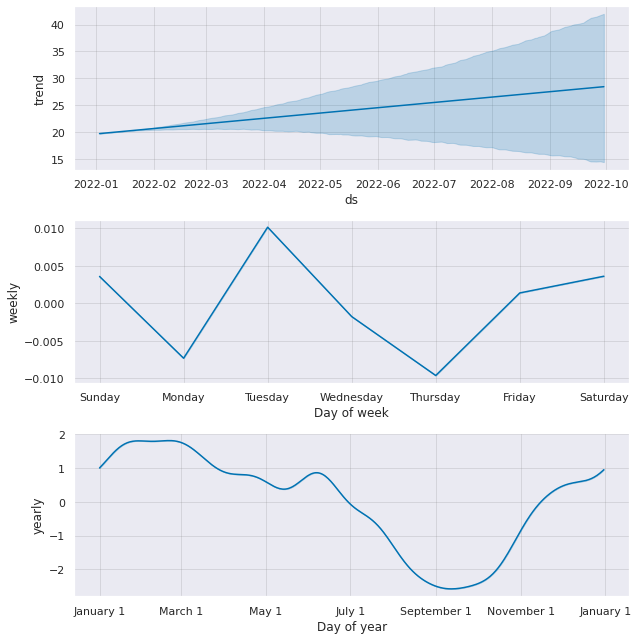

In [86]:
fig = model_prophet.plot_components(test_prophet)

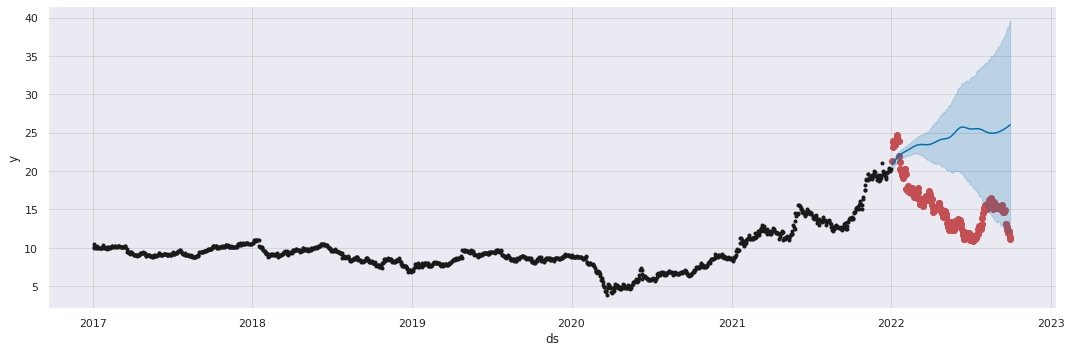

In [90]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test_df.index, test_df["Close"], color='r')
fig = model_prophet.plot(test_prophet, ax=ax)

Как видим, модель не угадывает перелом тренда на негативный, хотя справедливости ради следует отметить, что он не вытекал из предшествующих данных ("черный лебедь"). Если судить только из тестовых данных до 2022 года, то визуально прогноз не так плох

In [110]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def eval_accuracy(y_true, y_pred):
    """
    y_true - actual values as pandas series
    y_pred - predicted values as pandas series
    return: dictionary with MAE, RMSE and MAPE metrics
    """
    #mean absolute error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    
    #root mean squared error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    #mean absolute percentage error (MAPE)
    mape = np.mean(np.abs((y_true-y_pred) / y_true)) * 100
    
    return {'MAE': round(mae, 3),
           'RMSE': round(rmse, 3),
           'MAPE': round(mape, 3)}

In [111]:
eval_accuracy(test_df["Close"], test_prophet['yhat'])

{'MAE': 9.161, 'RMSE': 9.866, 'MAPE': nan}

In [114]:
np.mean(test_df["Close"]), mean_absolute_error(test_df["Close"], test_prophet['yhat']) / np.mean(test_df["Close"]) * 100

(15.365716568967128, 59.6219937002915)

Ошибка прогноза получилась весьма значительной: средняя абсолютная ошибка 9.161 при среднем значении временного ряда 15.366, т.е. ошибаемся где-то примерно на 60%, однако в данном случае динамика оказалась слишком непредсказуемой. Если обучить модель включая данна на начало текущего года, очевидно качество модели повысится значительно